<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/SalaryModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan

    100% |████████████████████████████████| 50.0MB 797kB/s 
    100% |████████████████████████████████| 2.1MB 12.8MB/s 


### ライブラリのインポート

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pystan
import pandas as pd
from scipy.stats import mstats
%matplotlib inline

### データの準備
RとStanでベイズ統計モデリングの階層ベイズモデルを参考に下記のモデルから疑似データを作成

$$
\begin{align}
KID &= {1, ..., 4} \\
n & = {1, ..., 200} \\
a[k] &\sim  \mathcal N(10, 15) \\
b[k] &\sim  \mathcal N(20, 3) \\
y[n] & \sim \mathcal N (a[KID[n]] + b[KID[n]] * x)
\end{align}
$$


$KID$ は会社を識別するID

$n$ は労働者を識別するID

( $KID[n]$ は 労働者 $n$ の所属する会社IDを表す） 

$a[k]$ は会社 $k$ の基本的な給与を表す確率変数

$b[k]$  は会社 $k$ の昇給幅を表す確率変数

$ x$ は年齢



要するに、異なる4つの会社から、合計200 人の年収を1年毎に調べ上げたデータである。

In [0]:
N = 200
K = 4

def get_data():
    
    a0 = 350.
    b0 = 20.
    s_a = 40.
    s_b = 5.
    s_Y = 30.

    
    a = np.random.normal(loc=a0, scale=s_a, size=(K,))
    b = np.random.normal(loc=b0, scale=s_b, size=(K,))
    
    KID = []
    X = []
    Y = []
    
    for n in range(N):
        kid = np.random.randint(0, K, 1)
        KID.append(int(kid))
        
        x = np.random.randint(22, 45, 1)
        X.append(x)
        
        Y.append(np.random.normal(loc=a[kid]+b[kid]*(x-22), scale=s_Y))

    return (np.array(X).reshape(N, 1).astype(np.float32), 
            np.array(Y).reshape(N, 1), 
            np.array(KID).reshape(N, 1).astype(np.int32))

#### 45歳までの各社の年収

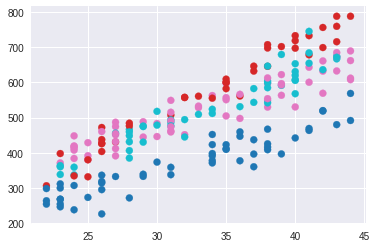

In [146]:
X_data, Y_data, KID_data = get_data()
plt.scatter(X_data, Y_data, c=KID_data, cmap='tab10')

In [0]:
df = pd.DataFrame(np.hstack([X_data, Y_data, KID_data]), 
                  columns=['age', 'salary', 'KID'])

In [148]:
df.head()

,age,salary,KID
0,38.0,645.648755,1.0
1,27.0,430.525794,1.0
2,34.0,377.673473,0.0
3,35.0,411.271965,0.0
4,22.0,306.112097,1.0


### 上記のデータの素性を知らない設定でモデリングを行う

### 年齢が増えると年収が増えると考える
データの素性を吟味していないため、データは下記のように見える。すると、単に年齢が増えたら年収も増えると考えてもおかしくはないだろう。


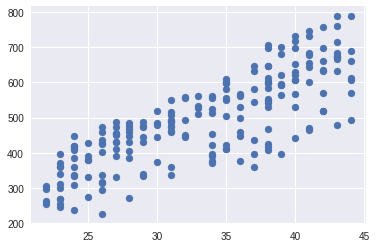

In [149]:
plt.scatter(df['age'], df['salary'])

#### モデリング
このような場合には下記のようにモデリングをしてみる。

$$
\begin{align}
n & = 1, 2, ..., N \\
z &= a + b(x - 22) \\\
y &\sim \mathcal N(z, \sigma_y^2)
\end{align}
$$

複雑に見えるかもしれないが、概ね書きように読める。

・新卒時年収 $a$ には無情報事前分布を使う。

・1年毎の昇給$b$も同様。

・合計 $N$ 人を選出している。

・$x$ 歳の基本年収 $z$は新卒年収$a$から毎年 $b$だけ上がる

・個人、年ごとの出来栄えで実際の年収 $y[n]$ は $\sigma_y^2$だけバラつく。 

In [0]:
stan_model = """
  data {
    int N;
    real X[N];
    real Y[N];
    int N_s;
    real X_s[N_s];
  }
  parameters {
    real a;
    real b;
    real<lower=0> sigma; 
  }
  model{
    for (n in 1:N){
      Y[n] ~ normal(a + b * (X[n] - 22), sigma);
    }
  }
  generated quantities {
    real Y_s[N_s];
    for (n in 1:N_s){
      Y_s[n] = normal_rng(a + b * (X_s[n] - 22), sigma);
    }
  }
"""

In [151]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d230ad28d19badf1a085e4dfa1d8a97 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp4nhftijx/stanfit4anon_model_4d230ad28d19badf1a085e4dfa1d8a97_104731520926299739.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


#### データを辞書で渡す
$X_s$ は推論済みのモデルを使って年収の予測をするための年齢の範囲である。

In [0]:
X_s = np.arange(22, 60, 1)
N_s = X_s.shape[0]
stan_data = {"N":df.shape[0], "X":df["age"], "Y":df["salary"], "N_s":N_s, "X_s":X_s}

In [0]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=1992)

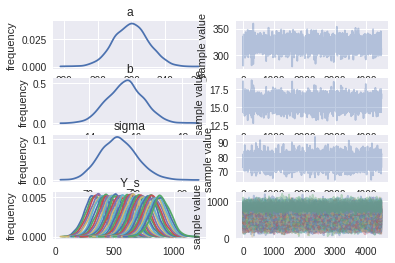

In [154]:
fig = fit.plot()

#### 新卒年収 $a$ を調べる
書きを見ると概ね320万円辺り、高い人だと340万円、低い人だと290万円くらいである。

なかなか現実的かもしれない…。

(array([   9.,   25.,  161.,  663., 1227., 1360.,  757.,  256.,   39.,
           3.]), array([277.80806547, 285.99659945, 294.18513343, 302.37366741,
        310.56220138, 318.75073536, 326.93926934, 335.12780332,
        343.3163373 , 351.50487127, 359.69340525]), <a list of 10 Patch objects>)

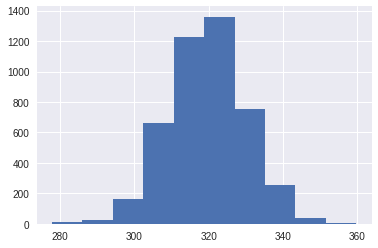

In [155]:
ms_a = fit.extract("a")["a"]
plt.hist(ms_a)

#### 昇給 $b$ 見る
昇給額は年に23万円くらいだろうか、高い人だと極少数だが27万円くらい昇給しているらしい。

(array([   8.,   68.,  367.,  862., 1349., 1096.,  556.,  160.,   23.,
          11.]),
 array([12.74995632, 13.34496008, 13.93996385, 14.53496761, 15.12997138,
        15.72497515, 16.31997891, 16.91498268, 17.50998644, 18.10499021,
        18.69999397]),
 <a list of 10 Patch objects>)

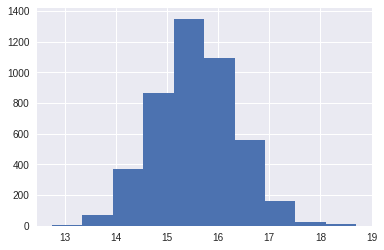

In [156]:
ms_b = fit.extract("b")["b"]
plt.hist(ms_b)

#### 情報の要約を見る
`fit` オブジェクトに全てが詰まっているので、（今回はパラメータが少ないのでいいですが）下記の見方を知っておくと良いでしょう。


In [157]:
fit

Inference for Stan model: anon_model_4d230ad28d19badf1a085e4dfa1d8a97.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       319.61    0.23  10.28 299.29 312.63 319.71 326.48 339.69   2055    1.0
b        15.56    0.02   0.79  14.06  15.02  15.56  16.08   17.1   1984    1.0
sigma    76.54    0.08   3.89  69.45  73.81  76.39  79.07  84.62   2648    1.0
Y_s[1]  320.84    1.14  76.78 168.58 269.45 320.42 371.65 473.25   4573    1.0
Y_s[2]  335.74    1.17  77.49  182.3 284.95 335.72  388.2 484.91   4376    1.0
Y_s[3]  349.09    1.13  75.85 198.25 299.26 350.18  400.3 497.66   4528    1.0
Y_s[4]  365.62    1.16  77.17  209.6 314.59 365.61 417.23 516.71   4440    1.0
Y_s[5]  381.15    1.15  77.75 227.83 329.66 382.81 433.42 530.31   4533    1.0
Y_s[6]  396.71    1.18  76.43 245.57 343.59 396.32 448.22  548.9   4161    1.0
Y_s[7]  414.36    1.19

#### ベイズ予測分布で還暦までの年収を見てみよう
ベイズ予測分布の信頼区間を見ると、今回の調査の範囲では95パーセントの人が還暦時に700〜1000万円強の間におさまっているらしい。

これを見る限り、贅沢はできないかもしれないが生活には特に困る感じは無さそうだ。

In [0]:
Y_p = fit.extract("Y_s")["Y_s"]

In [0]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025, 0.975], axis=0)

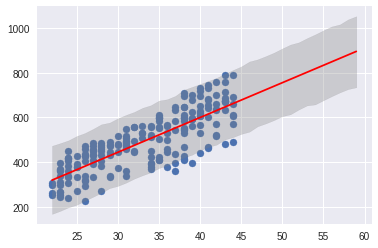

In [168]:
plt.scatter(df["age"], df["salary"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")
a_ = 319.61
b_ = 15.56
x_ = np.arange(22, 60, 1) 
y_ = a_ + b_ * (x_ - 22)
plt.plot(x_, y_, c='r')

### 階層ベイズモデル
#### モデリング
よく調べると、データは4つの会社からランダムに従業員が選ばれていたことが分かった（すなわち、本来のデータの生成過程に気づいた）。

このような場合には下記のようにモデリングをしてみる。  

$$
\begin{align}
a[k] &\sim \mathcal(a_{mean}, \sigma_a^2)\\
b[k] &\sim \mathcal(b_{mean}, \sigma_b^2)\\
KID[n] &= \{1, 2, 3, 4\}\\
n & = 1, 2, ..., N \\
z[n] &= a[KID[n]] + b[KID[n]](x - 22) \\\
y[n] &\sim \mathcal(z, \sigma_y^2)
\end{align}
$$


複雑に見えるかもしれないが、概ね書きように読める。

・ある会社$k$の新卒時年収は大体$a_{mean}$であり、会社によって $\sigma_a^2$ くらいバラける。

・ある会社$k$の1年毎の昇給は大体$b_{mean}$であり、会社によって $\sigma_a^2$ くらいバラける。

・会社の種類 $KID$ は ４種類であり、4つの会社から合計 $N$ 人を選出している。

・ある会社員$n$の$x$ 歳の基本年収 $z[n]$は所属する会社の新卒年収$a[KID[n]]$から毎年 $b[KID[n]]$だけ上がる

・個人、年ごとの出来栄えで実際の年収 $y[n]$ は $\sigma_y^2$だけバラつく。

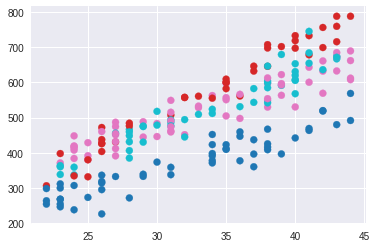

In [161]:
plt.scatter(X_data, Y_data, c=KID_data, cmap='tab10')

In [0]:
stan_model2 = """
  data {
    int N;
    int K;
    real X[N];
    real Y[N];
    int<lower=1, upper=K> KID[N];
    int N_s;
    real X_s[N_s];
  }
  
  parameters {
    real a0;
    real b0;
    real a[K];
    real b[K];
    real<lower=0> s_a;
    real<lower=0> s_b;
    real<lower=0> s_Y;
  }
  
  model{
    for (k in 1:K){
      a[k] ~ normal(a0, s_a);
      b[k] ~ normal(b0, s_b);
    }
  
    for (n in 1:N){
      Y[n] ~ normal(a[KID[n]] + b[KID[n]] * (X[n] - 22) , s_Y);
    }
  }
  
  generated quantities {
    real Y_s[N_s];
    for (n in 1:N_s){
      Y_s[n] = normal_rng(a[KID[n]] + b[KID[n]] * (X_s[n] - 22), s_Y);
    }
  }
"""

In [163]:
sm2 = pystan.StanModel(model_code=stan_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b7101b2543bb8b2597649e0c86fb23f NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpvl2zc1wt/stanfit4anon_model_0b7101b2543bb8b2597649e0c86fb23f_986132671402281509.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


#### データを辞書で渡す。
KIDのデータの型をintに変換して、定義域を1~4にしておきます。

（PythonとStanではindexの開始が異なるため注意）

In [0]:
df['KID'] = df['KID'].astype(np.int64) + 1

In [0]:
X_s = np.arange(22, 60, 1)
N_s = X_s.shape[0]
stan_data = {"N":df.shape[0], "K":4, "X":df["age"], "Y":df["salary"], 
             "KID": df["KID"], "N_s":N_s, "X_s":X_s}

In [0]:
fit2 = sm2.sampling(data=stan_data, iter=10000, warmup=2000, chains=3, seed=1992)

#### 情報の要約を見る
今回は1つ1つをヒストグラムにしたらまあまあ面倒なので一気に見てしまいます。



In [167]:
fit2

Inference for Stan model: anon_model_0b7101b2543bb8b2597649e0c86fb23f.
3 chains, each with iter=10000; warmup=2000; thin=1; 
post-warmup draws per chain=8000, total post-warmup draws=24000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0       329.0    1.23  75.74 200.61 302.29 327.76 353.87 459.13   3777    1.0
b0       14.94    0.14   7.06   4.07  12.84  14.99  17.05  25.91   2717    1.0
a[1]    258.16    0.06    7.8 242.85 252.91 258.16 263.42 273.52  16841    1.0
a[2]    336.46    0.08   10.1 316.67 329.59 336.54 343.28 356.19  16938    1.0
a[3]    379.52    0.06   8.04 363.81 374.09 379.46 384.91 395.58  17492    1.0
a[4]    336.18    0.07   9.77  317.0 329.53 336.25 342.83 355.34  17243    1.0
b[1]     11.27  4.9e-3   0.64   10.0  10.85  11.27   11.7  12.52  17172    1.0
b[2]     20.24  5.8e-3   0.74  18.78  19.74  20.24  20.74  21.69  16633    1.0
b[3]      12.3  4.6e-3   0.61  11.09  11.89   12.3   12.7  13.48  17504    1.0
b[4]     16.25  5.5

#### 会社差が明らかに！
さて、$a[k]$ と $b[k]$ の項目に着目しましょう。

明らかに会社ごとの差が出ています。

これを可視化すると更に明らかです。全体のベイズ予測分布の95%信頼区間と、個々の会社に着目した予測では全く異なっています。

ほとんど会社で決まってしまっているようです。

In [0]:
Y_p = fit.extract("Y_s")["Y_s"]

In [0]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025, 0.975], axis=0)

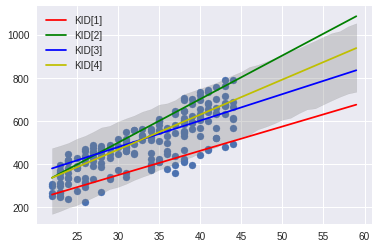

In [174]:
plt.scatter(df["age"], df["salary"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")

a_ = 258.16
b_ = 11.27
x_ = np.arange(22, 60, 1) 
y_ = a_ + b_ * (x_ - 22)
plt.plot(x_, y_, c='r')

a_ = 336.26
b_ = 20.24
x_ = np.arange(22, 60, 1) 
y_ = a_ + b_ * (x_ - 22)
plt.plot(x_, y_, c='g')

a_ = 379.52
b_ = 12.3
x_ = np.arange(22, 60, 1) 
y_ = a_ + b_ * (x_ - 22)
plt.plot(x_, y_, c='b')

a_ = 336.18
b_ = 16.25
x_ = np.arange(22, 60, 1) 
y_ = a_ + b_ * (x_ - 22)
plt.plot(x_, y_, c='y')


plt.legend(["KID[1]", "KID[2]", "KID[3]", "KID[4]"])

### まとめ
#### データの生成過程を想像してモデリング
まず、データに対して安易に直線フィッティングしても意味が無いかもしれません。

今回は人工的なデータで検証したため「4つの会社からの抽出」ということをキッチリとモデリングすることで、はっきりと違いが出ることを見ました。

#### なぜに個々にフィッティングしないか → グローバルパラメータ
さて、最後の図を見て感じたことがあるのではないでしょうか。

それは、4つの会社からデータを抽出していることがわかった時点で、それぞれの会社のデータ毎にフィッティング（モデルを4つ考えてしまえばいい）という方向性でやれば良いのではないか？ということです。

今回は、社会的な背景によって会社によらずに平均的な新卒年収があり、そこを中心として会社ごとにずれるというモデルにすることで、「全てのデータを使って」一つの正規分布をフィットすれば良くなったのです（昇給額も同様）。